<a id='sommaire'></a>
<h1 style='text-align:center;border:5px double;border-color:gray;'>
    <br/>
     PROJET 9<br/>
    <br/>
    <font color = 'green'>"Prédisez la demande en électricité"</font><br/>
    <br/>
</h1>

## [Pré-analyse](#p1)
* [Jeu de données Consommation](#1)  
* [Jeu de données météo](#2)  
* [Degrés jours unifiés (DJU)](#3) 


## [Désaisonnalisez à l'aide de la régression linéaire](#p2)



## [Modèle de Holt-Winters](#p3)




## [Modèle de SARIMA](#p4)


In [1]:
import pandas as pd
import numpy as np 
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox


from scipy.stats import shapiro

#from ljungbox import *

import warnings
warnings.filterwarnings('ignore')

C:\Users\pouri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\pouri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


<a id='p1'></a>

### Pré-analyse

<a id='1'></a>

### Jeu de données Consommation

[Haut de page](#sommaire)

In [2]:
#importer le DF
df = pd.read_csv("consommation.csv", encoding = "ISO-8859-1", engine='python', sep="\t")
print(df.shape)
df.head(3)

(1076, 23)


,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges aves la Suisse,Echanges avec l'Allemagne et la Belgique,Unnamed: 22
0,0000-00,Données consolidées,Grand-Est,7296,5505.0,864,153.0,8,701,537,...,3364,3876.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000-00,Données définitives,Nouvelle-Aquitaine,4523,3740.0,26,NaN,9,16,162,...,3222,1300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000-00,Données définitives,Auvergne-Rhône-Alpes,8890,5946.0,32,4.0,17,10,2632,...,5010,3658.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#sélectionner les colonnes souhaitées
df=df[['Mois','Territoire','Consommation totale']]

In [4]:
#sélectionner les rows de la France
consommation_france=df.loc[df['Territoire']=='France',['Mois','Consommation totale']]
display(consommation_france.head(3))
display(consommation_france.tail(3))

,Mois,Consommation totale
6,0000-00,34585
13,2010-01,56342
14,2010-02,48698


,Mois,Consommation totale
1043,2019-05,35599
1056,2019-06,32571
1069,2019-07,34606


<AxesSubplot:>

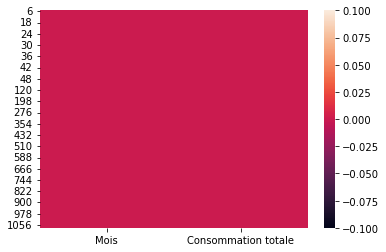

In [5]:
sns.heatmap(consommation_france.isna())

In [6]:
consommation_france.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 6 to 1069
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Mois                 116 non-null    object
 1   Consommation totale  116 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.7+ KB


**On peut noter que nous n'avons pas de données manquantes**

In [7]:
consommation_france.describe()

,Consommation totale
count,116.000000
mean,40327.370690
std,7233.511864
min,31004.000000
25%,33945.500000
50%,37630.500000
75%,46062.750000
max,57600.000000


In [8]:
#supprimer la première ligne car le mois est 0
consommation_france=consommation_france.drop(consommation_france.index[0]).reset_index(drop=True)

#objet a datatime
consommation_france['Mois']=pd.to_datetime(consommation_france["Mois"])

#choisir les valeur superieure a zero
consommation_france=consommation_france.loc[consommation_france['Consommation totale']>0,:]

#renommer la colonne
consommation_france=consommation_france.rename(columns={'Consommation totale': 'Consommation_totale'})

display(consommation_france.head(3))
display(consommation_france.tail(3))

,Mois,Consommation_totale
0,2010-01-01,56342
1,2010-02-01,48698
2,2010-03-01,48294


,Mois,Consommation_totale
112,2019-05-01,35599
113,2019-06-01,32571
114,2019-07-01,34606


Text(0, 0.5, 'Consommation totale')

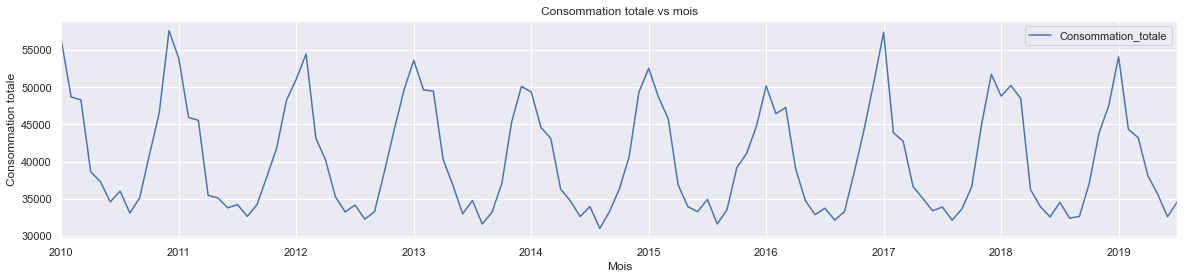

In [9]:
#tracer le lineplot
sns.set(rc={'figure.figsize':(20, 4)})
consommation_france.plot(y="Consommation_totale",x='Mois')
plt.title('Consommation totale vs mois')
plt.ylabel('Consommation totale')

<a id='2'></a>

### Jeu de données météo

[Haut de page](#sommaire)

#### Climatisation

In [10]:
meteo=pd.read_excel('climatisation.xlsx',skiprows=11)
meteo

,Année,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
0,2019,0,0,0,0.7,0.0,9.6,0.0,0.0,0.0,0.0,0,0,10.3
1,2018,0,0,0,6.9,18.4,32.6,137.9,78.0,9.4,4.3,0,0,287.3
2,2017,0,0,0,0.0,24.7,69.9,60.1,37.6,1.2,0.0,0,0,193.4
3,2016,0,0,0,0.0,0.0,14.4,58.1,70.0,28.5,0.0,0,0,171.0
4,2015,0,0,0,0.0,0.6,34.6,92.8,73.7,0.0,0.0,0,0,201.6
5,2014,0,0,0,0.0,0.0,13.7,56.0,10.7,14.1,0.0,0,0,94.4
6,2013,0,0,0,0.0,0.0,13.5,98.6,42.0,9.7,0.0,0,0,163.7
7,2012,0,0,0,0.0,12.1,10.4,32.3,63.2,7.3,0.0,0,0,125.2
8,2011,0,0,0,1.4,5.1,31.1,7.2,34.9,23.2,4.3,0,0,107.2
9,2010,0,0,0,0.3,7.4,34.7,75.7,25.4,0.0,0.0,0,0,143.4


In [11]:
meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Année   10 non-null     int64  
 1   JAN     10 non-null     int64  
 2   FÉV     10 non-null     int64  
 3   MAR     10 non-null     int64  
 4   AVR     10 non-null     float64
 5   MAI     10 non-null     float64
 6   JUN     10 non-null     float64
 7   JUI     10 non-null     float64
 8   AOÛ     10 non-null     float64
 9   SEP     10 non-null     float64
 10  OCT     10 non-null     float64
 11  NOV     10 non-null     int64  
 12  DÉC     10 non-null     int64  
 13  Total   10 non-null     float64
dtypes: float64(8), int64(6)
memory usage: 1.2 KB


In [12]:
#mettre les annees comme index
meteo=meteo.set_index('Année')

#suprimmer la colonne total
meteo=meteo.drop(columns=['Total'])

#changer les noms de colonnes
meteo=meteo.rename(columns={"JAN": "01", "FÉV":"02", "MAR":"03", "AVR":"04",
                      "MAI":"05", "JUN":"06", "JUI":"07", "AOÛ":"08", "SEP":"09",
                      "OCT":"10", "NOV":"11", "DÉC":"12"})

In [13]:
meteo_newformat={'mois':[],'climatisation':[]}

In [14]:
for Année in meteo.index.values:
    for mois in meteo.columns:
        meteo_newformat['mois'].append(f"{Année}-{mois}-01")
        meteo_newformat['climatisation'].append(meteo.loc[Année,mois])    
       

In [15]:
meteo_newformat=pd.DataFrame(meteo_newformat)

#objet a datatime
meteo_newformat['mois']=pd.to_datetime(meteo_newformat['mois'])

meteo_newformat.head()

,mois,climatisation
0,2019-01-01,0.0
1,2019-02-01,0.0
2,2019-03-01,0.0
3,2019-04-01,0.7
4,2019-05-01,0.0


#### Chauffage

In [16]:
meteo_chau=pd.read_excel('chauffage.xlsx',skiprows=11)
#meteo.info()
meteo_chau=meteo_chau.set_index('Année')
meteo_chau=meteo_chau.drop(columns=['Total'])
meteo_chau=meteo_chau.rename(columns={"JAN": "01", "FÉV":"02", "MAR":"03", "AVR":"04",
                                      "MAI":"05", "JUN":"06", "JUI":"07",   "AOÛ":"08",
                                      "SEP":"09", "OCT":"10", "NOV":"11", "DÉC":"12"})

In [17]:
meteo_newformat_chau={'mois':[],'chauffage':[]}

for Année in meteo.index.values:
    for mois in meteo_chau.columns:
        meteo_newformat_chau['mois'].append(f"{Année}-{mois}-01")
        meteo_newformat_chau['chauffage'].append(meteo_chau.loc[Année,mois])

meteo_newformat_chau=pd.DataFrame(meteo_newformat_chau)
meteo_newformat_chau['mois']=pd.to_datetime(meteo_newformat_chau['mois'])

meteo_newformat_chau.head()

,mois,chauffage
0,2019-01-01,466.9
1,2019-02-01,324.3
2,2019-03-01,295.1
3,2019-04-01,223.5
4,2019-05-01,176.8


<a id='3'></a>

### Degrés jours unifiés (DJU)

[Haut de page](#sommaire)

In [18]:
dju=meteo_newformat.merge(meteo_newformat_chau,on='mois',how='inner')

In [19]:
dju['dju']=dju['chauffage']+dju['climatisation']
print(dju.shape)
dju.head(7)

(120, 4)


,mois,climatisation,chauffage,dju
0,2019-01-01,0.0,466.9,466.9
1,2019-02-01,0.0,324.3,324.3
2,2019-03-01,0.0,295.1,295.1
3,2019-04-01,0.7,223.5,224.2
4,2019-05-01,0.0,176.8,176.8
5,2019-06-01,9.6,26.0,35.6
6,2019-07-01,0.0,0.0,0.0


<AxesSubplot:xlabel='mois'>

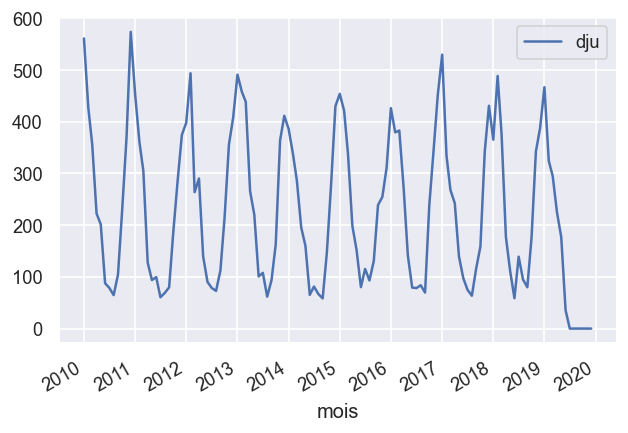

In [20]:
# Use seaborn style defaults and set the default figure size
#sns.set(rc={'figure.figsize':(20, 10)})
plt.rcParams.update({'figure.figsize': (6, 4), 'figure.dpi': 120})


# Série sunspot : nombre annuel de tâches solaires de 1790 à 1970
dju.plot(y="dju",x='mois')


In [21]:
print(f'shape de DJU {dju.shape}' )
print(f'shape de la consommaton {consommation_france.shape}')

shape de DJU (120, 4)
shape de la consommaton (115, 2)


In [22]:
# merge les dfs
df_con_dju =consommation_france.merge(dju,left_on='Mois',right_on='mois')
print(df_con_dju.shape)
df_con_dju.head()

(115, 6)


,Mois,Consommation_totale,mois,climatisation,chauffage,dju
0,2010-01-01,56342,2010-01-01,0.0,561.2,561.2
1,2010-02-01,48698,2010-02-01,0.0,427.4,427.4
2,2010-03-01,48294,2010-03-01,0.0,356.5,356.5
3,2010-04-01,38637,2010-04-01,0.3,222.3,222.6
4,2010-05-01,37284,2010-05-01,7.4,194.2,201.6


In [23]:
df_con_dju=df_con_dju.drop(['mois','chauffage','climatisation'],axis=1).set_index('Mois')
df_con_dju.isna().sum()

Consommation_totale    0
dju                    0
dtype: int64

In [24]:
df_con_dju.head(2)

,Consommation_totale,dju
Mois,,
2010-01-01,56342,561.2
2010-02-01,48698,427.4


In [25]:
df_con_dju= df_con_dju[:-1]

In [26]:
df_con_dju.describe()

,Consommation_totale,dju
count,114.000000,114.000000
mean,40427.929825,238.847368
std,7256.588773,144.873970
min,31004.000000,35.600000
25%,33938.500000,97.850000
50%,38027.500000,221.500000
75%,46314.250000,363.125000
max,57600.000000,574.000000


In [27]:
df_con_dju.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2010-01-01 to 2019-06-01
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Consommation_totale  114 non-null    int64  
 1   dju                  114 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 2.7 KB


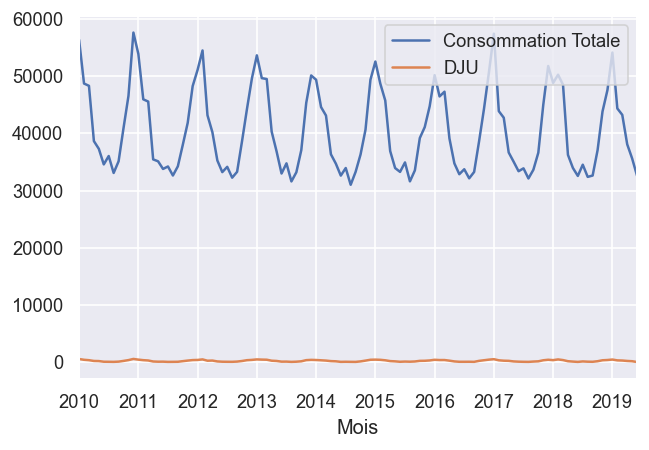

In [28]:
df_con_dju['Consommation_totale'].plot(label="Consommation Totale")
df_con_dju['dju'].plot(label="DJU")
plt.legend()

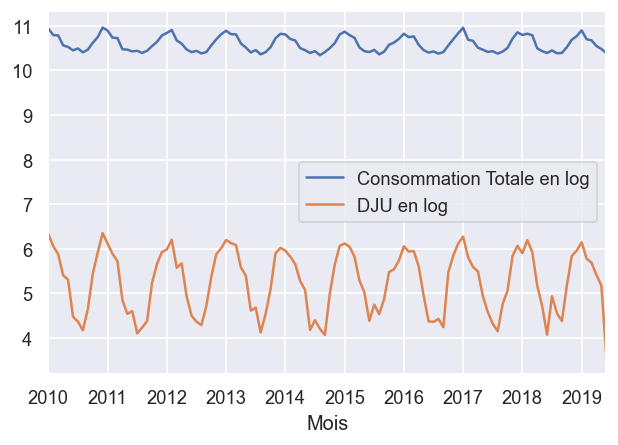

In [29]:
np.log(df_con_dju['Consommation_totale']).plot(label="Consommation Totale en log")
np.log(df_con_dju['dju']).plot(label="DJU en log")
plt.legend()

<a id='p2'></a>

## Désaisonnalisez à l'aide de la régression linéaire

[Haut de page](#sommaire)

In [30]:
df_con_dju.head(n=2)

,Consommation_totale,dju
Mois,,
2010-01-01,56342,561.2
2010-02-01,48698,427.4


In [31]:
df_con_dju['t'] = range(1, df_con_dju.shape[0] + 1)

In [32]:
df_con_dju.corr()

,Consommation_totale,dju,t
Consommation_totale,1.000000,0.980682,-0.088123
dju,0.980682,1.000000,-0.047390
t,-0.088123,-0.047390,1.000000


<AxesSubplot:xlabel='Consommation_totale', ylabel='dju'>

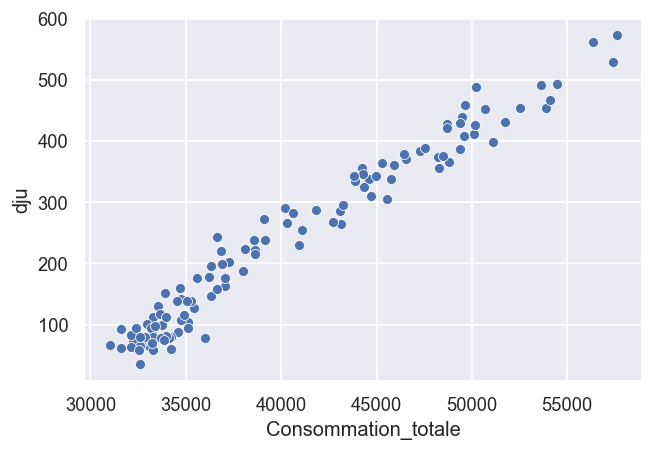

In [33]:
sns.scatterplot(data = df_con_dju, x ='Consommation_totale', y = 'dju' )

In [34]:
df_con_dju

,Consommation_totale,dju,t
Mois,,,
2010-01-01,56342,561.2,1
2010-02-01,48698,427.4,2
2010-03-01,48294,356.5,3
2010-04-01,38637,222.6,4
2010-05-01,37284,201.6,5
...,...,...,...
2019-02-01,44341,324.3,110
2019-03-01,43223,295.1,111
2019-04-01,38078,224.2,112


In [35]:
y = df_con_dju['Consommation_totale']
x = df_con_dju.drop(columns=['Consommation_totale'])

In [36]:
reg = linear_model.LinearRegression(fit_intercept=True)
regression = reg.fit(x, y)
regression

LinearRegression()

In [37]:
c = regression.coef_[0]
regression.coef_

array([49.02224916, -9.16414303])

In [38]:
regression.intercept_

29246.0328439068

In [39]:
serie_corrigee = df_con_dju['Consommation_totale'] - df_con_dju['dju'] * c

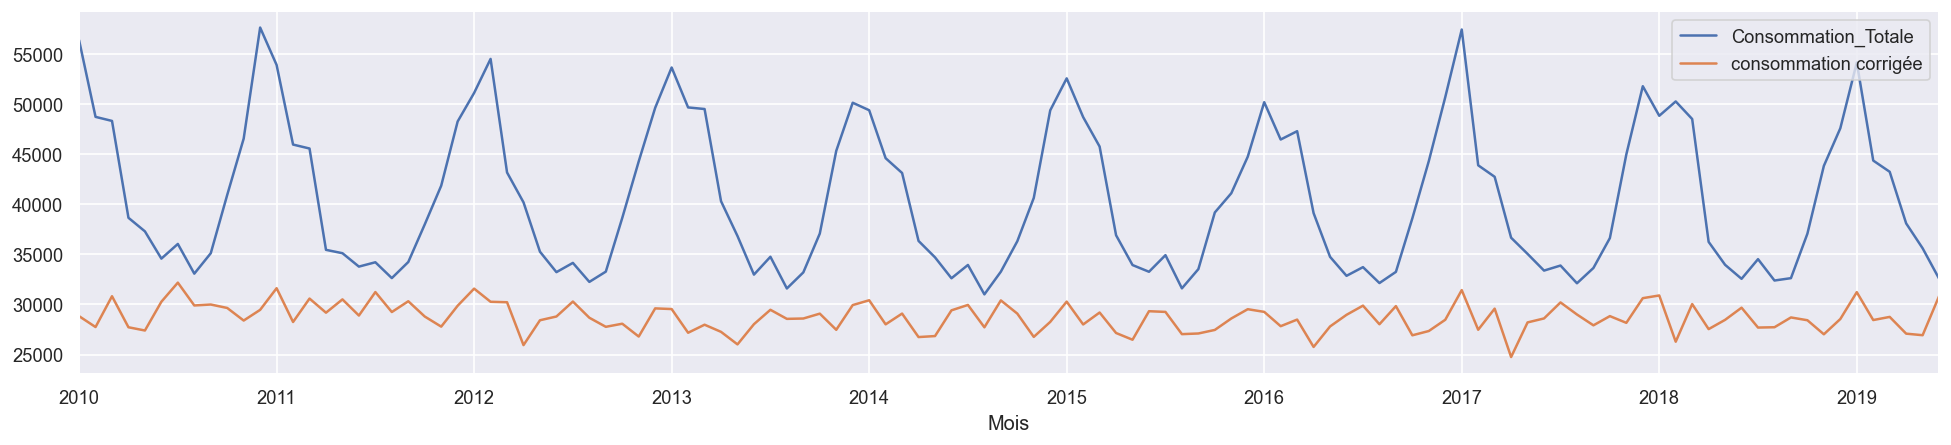

In [40]:
df_con_dju['Consommation_totale'].plot(figsize = (20,4), label="Consommation_Totale")
serie_corrigee.plot(label = 'consommation corrigée') 
plt.legend()
plt.show()

#### Statsmodel

In [41]:
reg_multip = smf.ols('Consommation_totale ~ t+dju', data=df_con_dju).fit()

In [42]:
reg_multip.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Consommation_totale   R-squared:                       0.963
Model:                             OLS   Adj. R-squared:                  0.963
Method:                  Least Squares   F-statistic:                     1464.
Date:                 Tue, 24 May 2022   Prob (F-statistic):           1.67e-80
Time:                         17:23:17   Log-Likelihood:                -986.02
No. Observations:                  114   AIC:                             1978.
Df Residuals:                      111   BIC:                             1986.
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.925e+04    348.793     83.849      0.000    2.86e+04    2.99e+04
t             -9.1641      3.987     -2.299      0.023     -17.065      -1.264
dju           49.0222      0.910     53.892      0.000      47.220      50.825
==============================================================================
Omnibus:                        0.221   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.896   Jarque-Bera (JB):                0.399
Skew:                          -0.017   Prob(JB):                        0.819
Kurtosis:                       2.712   Cond. No.                         754.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
serie_corr_df = pd.DataFrame({'Mois': serie_corrigee.index , 'corrigee' : serie_corrigee.values })
serie_corr_df.head(3)

,Mois,corrigee
0,2010-01-01,28830.713774
1,2010-02-01,27745.890711
2,2010-03-01,30817.568176


#### Test de normalité des résidus 

In [44]:
shapiro(reg_multip.resid)

ShapiroResult(statistic=0.9929186701774597, pvalue=0.8298814296722412)

[('Lagrande multiplier statistic', 2.9669561656799655), ('p-value', 0.22684732092462032), ('f-value', 1.4830365944119053), ('f p-value', 0.23140907327645593)]
Shapiro pvalue : 0.8298641443252563


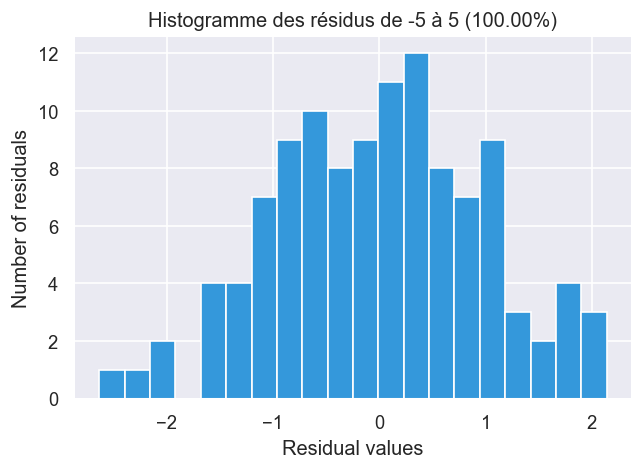

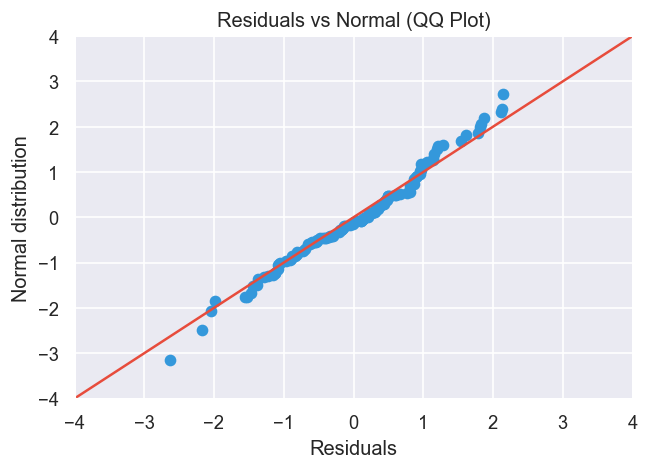

In [45]:
from functions1 import *

linear_regression_analysis(reg_multip)

### Désaisonnaliser

[Haut de page](#sommaire)

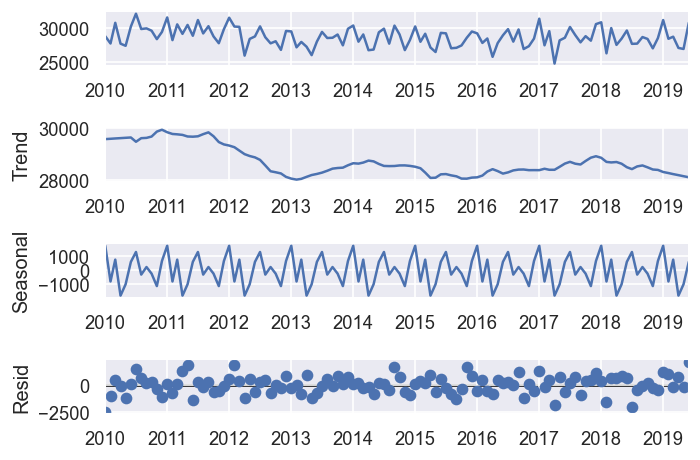

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp_x = seasonal_decompose(serie_corrigee, model='additive', extrapolate_trend='freq')
decomp_x.plot()
plt.show()

In [47]:
df_reconstructed = pd.concat([decomp_x.seasonal, decomp_x.trend, decomp_x.resid, decomp_x.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
Mois,,,,
2010-01-01,1733.437433,29580.183011,-2482.906669,28830.713774
2010-02-01,-793.508070,29592.672836,-1053.274055,27745.890711
2010-03-01,749.511854,29605.162662,462.893660,30817.568176
2010-04-01,-1796.015237,29617.652488,-96.989913,27724.647338
2010-05-01,-990.419421,29630.142313,-1238.608322,27401.114570


In [48]:
# decomp_x1 = seasonal_decompose(serie_corrigee,  model='multiplicative' )
# decomp_x1.plot()
# plt.show()

In [49]:
serie_corr_df['corrigee-saison']=serie_corrigee.values - decomp_x.seasonal.values

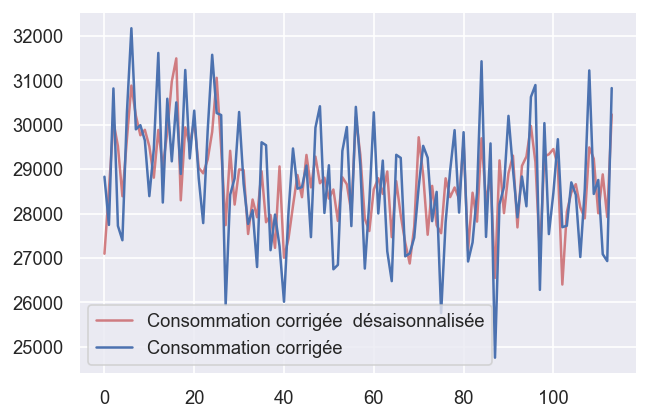

In [50]:
plt.plot(serie_corr_df["corrigee-saison"],'r', label="Consommation corrigée  désaisonnalisée", alpha=0.7)
plt.plot(serie_corr_df["corrigee"],'b', label="Consommation corrigée")
plt.legend()
plt.show()

In [51]:
serie_corr_df['MA']=serie_corr_df['corrigee'].rolling(12).mean()
serie_corr_df.tail()

,Mois,corrigee,corrigee-saison,MA
109,2019-02-01,28443.084599,29236.592669,28625.085711
110,2019-03-01,28756.534274,28007.022420,28518.386264
111,2019-04-01,27087.211739,28883.226976,28480.699492
112,2019-05-01,26931.866349,27922.285771,28353.070828
113,2019-06-01,30825.807930,30232.309346,28448.938658


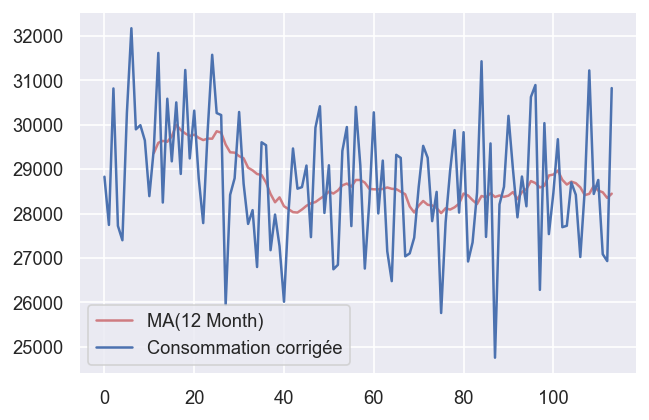

In [52]:
#moyenne mobole avec rolling()
plt.plot(serie_corr_df['MA'],'r', label="MA(12 Month)",  alpha=0.7)
plt.plot(serie_corr_df['corrigee'],'b', label="Consommation corrigée")
plt.legend()
plt.show()


**Et enfin pour la méthode de Holt-Winters :**

In [53]:
x_tronc = serie_corr_df.iloc[:-12,:]
x_a_prevoir = serie_corr_df.iloc[-12:,:]
display(x_tronc.tail(3))
display(x_a_prevoir.head(3))

,Mois,corrigee,corrigee-saison,MA
99,2018-04-01,27539.453000,29335.468236,28858.891422
100,2018-05-01,28463.410320,29453.829741,28880.158891
101,2018-06-01,29675.393975,29081.895390,28969.430459


,Mois,corrigee,corrigee-saison,MA
102,2018-07-01,27695.005143,26403.918051,28760.653278
103,2018-08-01,27726.886330,28034.415437,28654.803208
104,2018-09-01,28703.122293,28476.135873,28720.312920


___

<a id='p3'></a>

## Modèle de Holt-Winters

[Haut de page](#sommaire)

**Rq: modele additif ou multiplicatif ?**
    regarder les écarts sur une série temporelle mensuelle qui a une saisonnalité 
    annuelle (tous les deux points).
    Il suffit de regarder les écarts entre les piques et les creux 
    sur une période, si cet écart s accroit ou decroit on est sur un 
    modele multiplicatif

**Rq: time serie a 3 choses**
- une tendance (traduit le niveau moyen de la serie temp)
- une saisonnalité (c'est l ensemble des fluctualitées qu on va retrouver ds la ST, qlq chose de périodque)
- un résidu (la part qu'on ne peut pas expliquer)

In [54]:
from statsmodels.tsa.api import ExponentialSmoothing

y= np.asarray(x_tronc["corrigee"])
hw = ExponentialSmoothing(y, 
                          seasonal_periods=12, trend='add', 
                          seasonal='add').fit()
hw_pred = hw.forecast(12)

In [55]:
hw_pred

array([30694.34630945, 29056.88384768, 29369.13326179, 29052.03111844,
       28668.65807254, 30406.88151566, 31354.25034902, 27969.67620781,
       30363.59712216, 27332.29430271, 28744.74158618, 29875.23738586])

In [56]:
hw.params

{'smoothing_level': 0.23373617180416084,
 'smoothing_trend': 0.042459672312627046,
 'smoothing_seasonal': 0.3431384999880039,
 'damping_trend': nan,
 'initial_level': 30205.823465922764,
 'initial_trend': 4.151546479706354,
 'initial_seasons': array([ -952.75491416, -2456.0129342 ,   154.05227782, -2712.86168294,
        -2675.32566338,  -477.68629241,  1348.63511098,  -759.43527849,
         -542.82404923,  -944.5731166 , -2145.15449523,  -811.20639727]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [57]:
#racine de mean squar
np.sqrt(mean_squared_error(x_a_prevoir.corrigee, hw_pred ))

1438.8660820890295

In [58]:
x_a_prevoir.corrigee.mean(), np.sqrt(x_a_prevoir.corrigee.var())

(28448.9386577556, 1374.888120434547)

In [59]:
pd.date_range(x_tronc.Mois[x_tronc.shape[0] -1], periods=12, freq='M')

DatetimeIndex(['2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30',
               '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31',
               '2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31'],
              dtype='datetime64[ns]', freq='M')

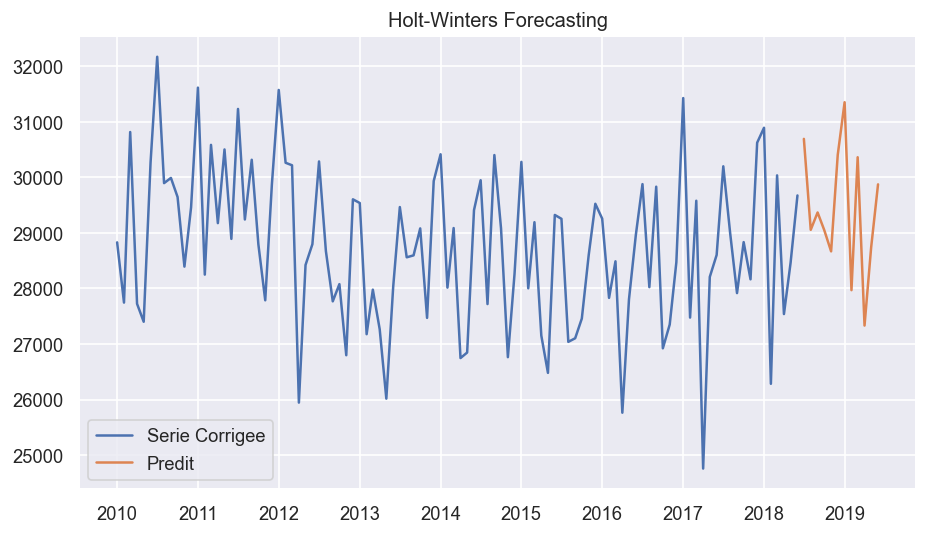

In [99]:
plt.plot(x_tronc['Mois'],x_tronc['corrigee'], label='Serie Corrigee')
plt.plot(pd.date_range(x_tronc.Mois[x_tronc.shape[0]-1], periods=12, freq='M'), hw_pred, label='Predit')
plt.title('Holt-Winters Forecasting')
plt.legend()
#plt.show()

In [61]:
serie_corr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Mois             114 non-null    datetime64[ns]
 1   corrigee         114 non-null    float64       
 2   corrigee-saison  114 non-null    float64       
 3   MA               103 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 3.7 KB


In [62]:
x_a_prevoir['prediction']=hw_pred.copy()

In [63]:
MAE=np.abs(x_a_prevoir['corrigee']-x_a_prevoir['prediction']).mean()
MAE

1195.702088092018

In [65]:
#Mean absolute percentage error (MAPE) regression loss
print(f'Modèle de Holt-Winters, mean absolute percentage error {mean_absolute_percentage_error(x_a_prevoir.corrigee, x_a_prevoir.prediction)}')

Modèle de Holt-Winters, mean absolute percentage error 0.04262662570980603


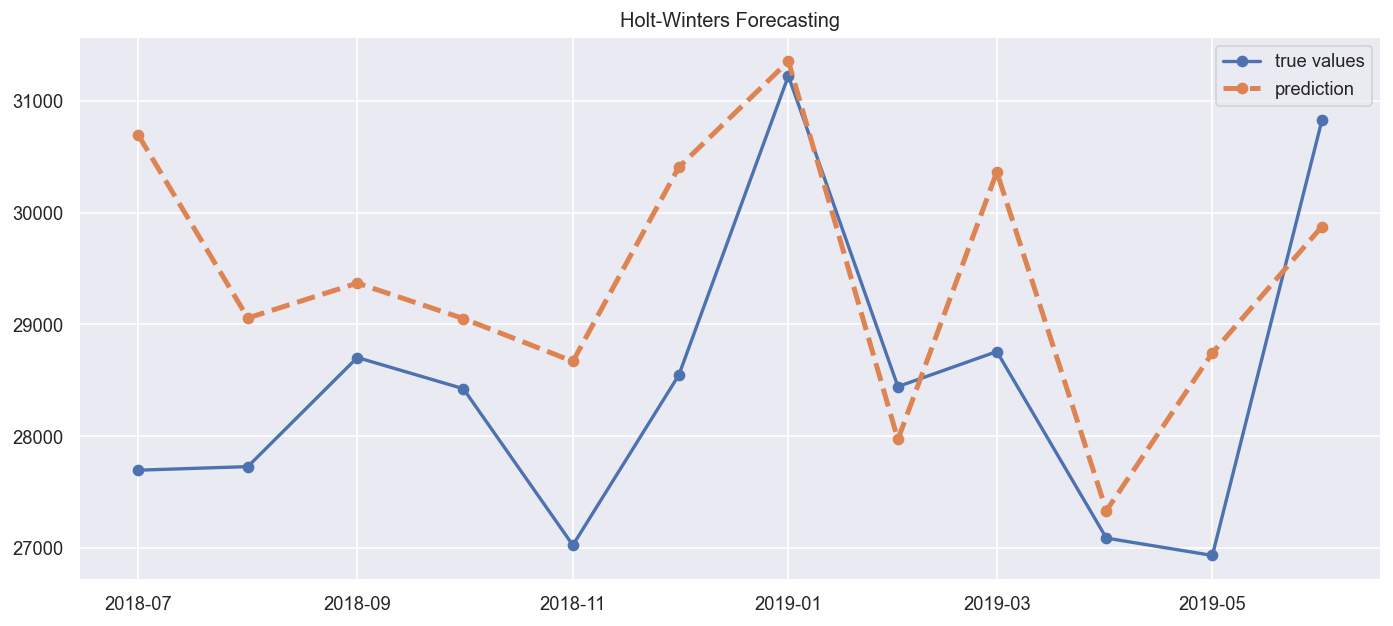

In [100]:
plt.figure(figsize=(14,6))
plt.plot(x_a_prevoir['Mois'],x_a_prevoir['corrigee'], label='true values', marker='o', linewidth=2)
plt.plot(x_a_prevoir['Mois'],x_a_prevoir['prediction'], label='prediction', linestyle='--', marker='o', linewidth=3)
plt.title('Holt-Winters Forecasting')
plt.legend()

<a id='p4'></a>

## Modèle de SARIMA

[Haut de page](#sommaire)

In [67]:
from statsmodels.tsa.stattools import adfuller, kpss

**Test de Dickey-Fuller**

hypothèses nulles et alternatives:
- H0 La série temporelle n'est pas stationnaire
- H1 La série temporelle est stationnaire

In [68]:
ad_fuller_result = adfuller(serie_corr_df['corrigee'])
 
print(f'ADF statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
print(f'Lags nums: {ad_fuller_result[2]}')
print(f'nums d observations utilisées pour la régulation ATF et le calcul des valeurs critiques: {ad_fuller_result[3]}')
print(f'Valeurs critiques:')
for key, val in ad_fuller_result[4].items():
    print("\t",key, ": ", val)

ADF statistic: -1.8246652229587625
p-value: 0.36828666459590575
Lags nums: 11
nums d observations utilisées pour la régulation ATF et le calcul des valeurs critiques: 102
Valeurs critiques:
	 1% :  -3.4961490537199116
	 5% :  -2.8903209639580556
	 10% :  -2.5821223452518263


In [69]:
# from pandas.plotting import autocorrelation_plot
# plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})

# autocorrelation_plot(serie_corrigee.values.tolist())

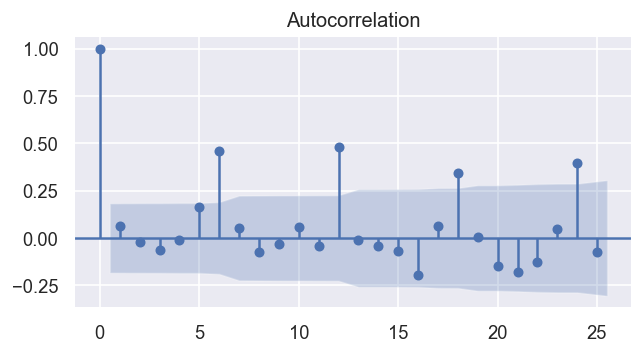

In [70]:
plt.rcParams.update({'figure.figsize':(6,3), 'figure.dpi':120})

acf = plot_acf(serie_corr_df['corrigee'], lags = 25);

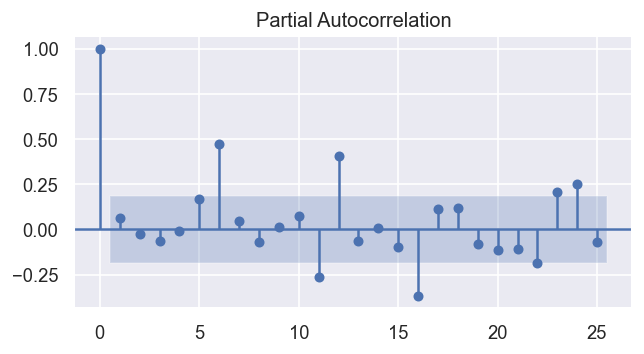

In [71]:
pacf = plot_pacf(serie_corr_df['corrigee'], lags = 25);

**La sortie ACF présente une décroissance lente vers 0, ce qui traduit un problème de non-stationnarité. On effectue donc une différenciation  (𝐼−𝐵).**

#### Stationnarisation de la série

**ACF**

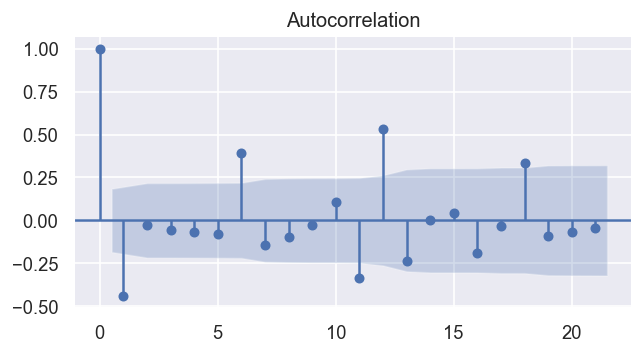

In [72]:
serie_corr_df_diff = serie_corr_df['corrigee'].diff()[1:]
plot_acf(serie_corr_df_diff);

In [73]:
# serie_corr_df_diff_2 = serie_corr_df['corrigee'].diff(periods = 12)[12:]
# plot_acf(serie_corr_df_diff_2);

**PACF**

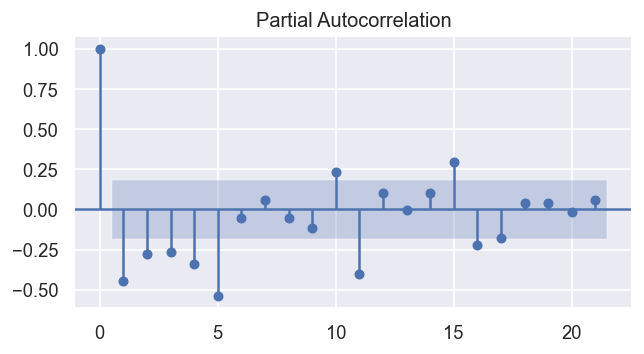

In [74]:
plot_pacf(serie_corr_df_diff);

**Test de Dickey-Fuller**

In [75]:
ad_fuller_result_2 = adfuller(serie_corr_df['corrigee'].diff()[1:])
 
print(f'ADF statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')    

ADF statistic: -5.411300979902718
p-value: 3.206914418515673e-06


- La série temporelle est stationnaire

In [76]:
# h, pV, Q, cV = lbqtest(serie_corr_df_diff, range(1, 20), alpha=0.1)
# print ('lag   p-value          Q    c-value   rejectH0')
# for i in range(len(h)):
#     print ("%-2d %10.3f %10.3f %10.3f      %s" % (i+1, pV[i], Q[i], cV[i], str(h[i])))

In [77]:
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox

model1 = SARIMAX(np.asarray(x_tronc["corrigee"]), order=(1,0,1), seasonal_order=(1,1,1,12))
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  102
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -766.227
Date:                            Tue, 24 May 2022   AIC                           1542.454
Time:                                    17:25:20   BIC                           1554.953
Sample:                                         0   HQIC                          1547.494
                                            - 102                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9489      0.031     30.241      0.000       0.887       1.010
ma.L1         -0.9064      0.036    -25.290      0.000      -0.977      -0.836
ar.S.L12       0.3682      0.131      2.815      0.005       0.112       0.625
ma.S.L12      -0.6148      0.166     -3.710      0.000      -0.940      -0.290
sigma2      1.719e+06   2.35e-09    7.3e+14      0.000    1.72e+06    1.72e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.10   Jarque-Bera (JB):                 0.92
Prob(Q):                              0.29   Prob(JB):                         0.63
Heteroskedasticity (H):               0.74   Skew:                            -0.22
Prob(H) (two-sided):                  0.42   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.29e+31. Standard errors may be unstable.
"""

In [78]:
ci = results1.conf_int(alpha=0.05)
ci

array([[ 8.87396376e-01,  1.01039667e+00],
       [-9.76632912e-01, -8.36145534e-01],
       [ 1.11827216e-01,  6.24514253e-01],
       [-9.39618627e-01, -2.90013438e-01],
       [ 1.71946275e+06,  1.71946275e+06]])

In [79]:
ci = results1.conf_int(0.05)
print('95%% Interval: %.3f to %.3f' % (ci[0,0], ci[0,1]))

95% Interval: 0.887 to 1.010


In [80]:
# result = model_fit.get_forecast()
# forecast = result.predicted_mean
# # summarize confidence intervals
# intervals = [0.2, 0.1, 0.05, 0.01]
# for a in intervals:
# 	ci = result.conf_int(alpha=a)
# 	print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, ci[0,0], ci[0,1]))

In [81]:
result = results1.get_forecast()
forecast = result.predicted_mean

In [82]:
# summarize confidence intervals
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
    ci = result.conf_int(alpha=a)
    print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, ci[0,0], ci[0,1]))

80.0% Confidence Interval: 30263.782 between 28583.272 and 31944.292
90.0% Confidence Interval: 30263.782 between 28106.871 and 32420.693
95.0% Confidence Interval: 30263.782 between 27693.664 and 32833.900
99.0% Confidence Interval: 30263.782 between 26886.075 and 33641.490


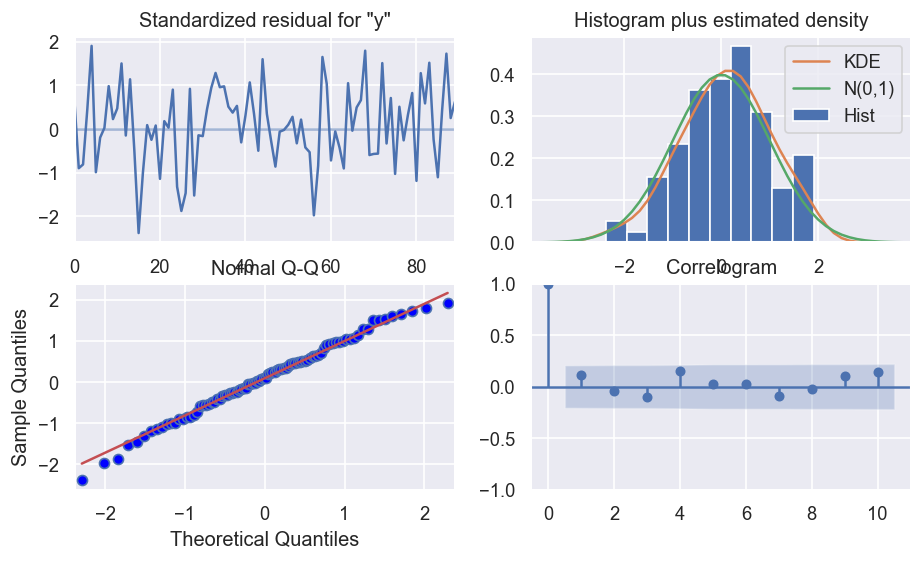

In [83]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})

results1.plot_diagnostics()
plt.show()

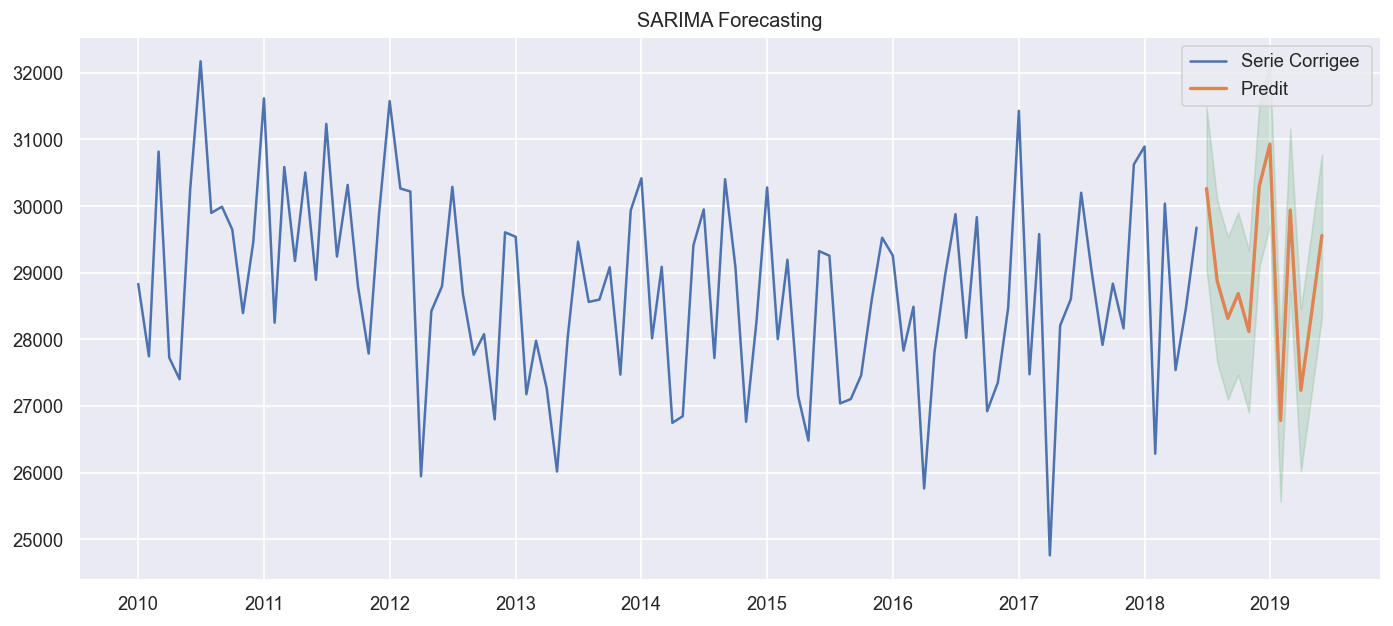

In [101]:
sarima_pred=results1.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(x_tronc['Mois'],x_tronc['corrigee'], label='Serie Corrigee ')
plt.plot(pd.date_range(x_tronc.Mois[x_tronc.shape[0]-1],
                       periods=12, freq='M'), sarima_pred, label='Predit', linewidth=2)

# For a 95% CI
i = 28803.732  * np.std(sarima_pred)/np.mean(sarima_pred)
plt.fill_between(pd.date_range(x_tronc.Mois[x_tronc.shape[0]-1],
                       periods=12, freq='M'), sarima_pred-i, sarima_pred+i, color='g',  alpha=.2)

plt.title('SARIMA Forecasting')

plt.legend()

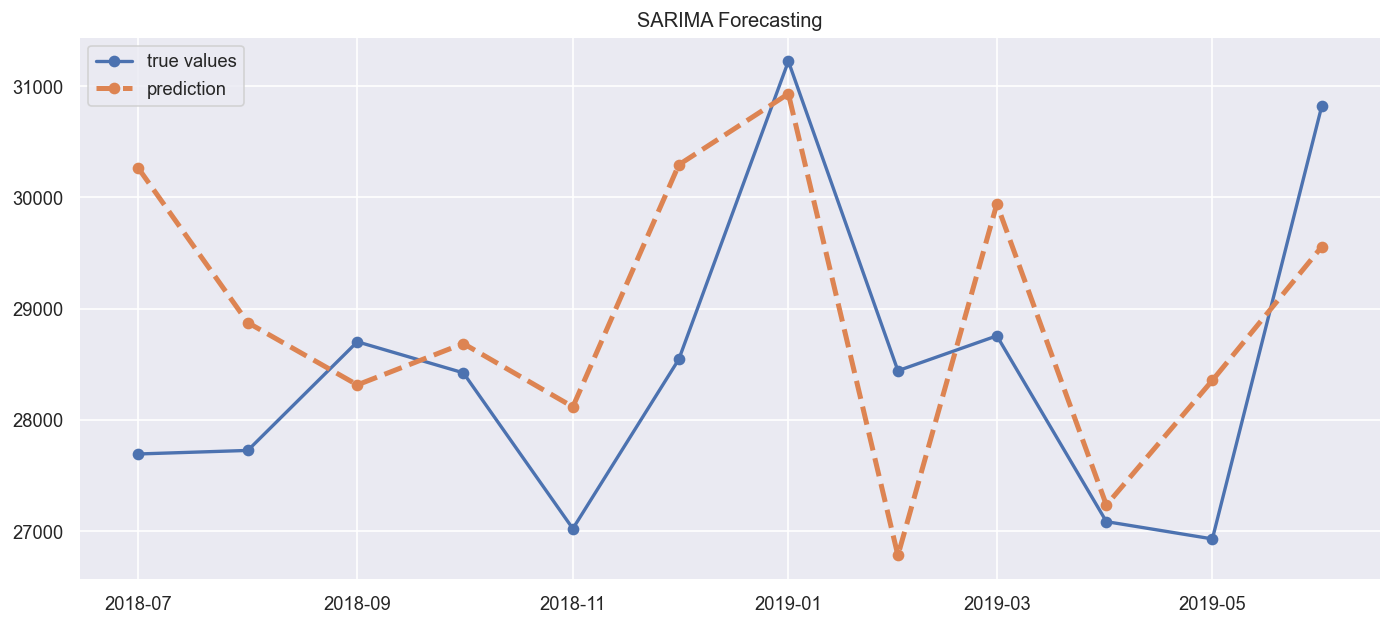

In [102]:
plt.figure(figsize=(14,6))
plt.plot(x_a_prevoir['Mois'],x_a_prevoir['corrigee'], label='true values', marker='o', linewidth=2)
plt.plot(x_a_prevoir['Mois'],sarima_pred, label='prediction', linestyle='--', marker='o', linewidth=3)
plt.title('SARIMA Forecasting')

plt.legend()

In [86]:
#racine de mean squar
np.sqrt(mean_squared_error(x_a_prevoir.corrigee, sarima_pred ))

1300.3049864466914

In [87]:
x_a_prevoir.corrigee.mean(), np.sqrt(x_a_prevoir.corrigee.var())

(28448.9386577556, 1374.888120434547)

In [88]:
print(f'Modèle de SARIMA, mean absolute percentage error {mean_absolute_percentage_error(x_a_prevoir.corrigee, sarima_pred)}')

Modèle de SARIMA, mean absolute percentage error 0.03892079383404369


### Optimal SARIMA

In [89]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
model2 = pm.arima.auto_arima(x_tronc["corrigee"],
                         test='adf',
                         #start_p = 7,
                         #max_p = 7, 
                         #start_q = 7,
                         #max_q = 7,    
                         m=12,
                         seasonal=True,
                         d=1,
                         #D=0, 
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

model2.summary();

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1787.697, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1819.819, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1793.182, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1797.644, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1817.825, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=1792.309, Time=1.55 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=1792.311, Time=1.50 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=1790.865, Time=1.40 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=1.61 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=1783.916, Time=0.71 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=1

In [90]:
model_2 = SARIMAX(np.asarray(x_tronc["corrigee"]), order=(1,1,0), seasonal_order=(1,0,1,12))
results2 = model_2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  102
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -884.950
Date:                              Tue, 24 May 2022   AIC                           1777.901
Time:                                      17:26:06   BIC                           1788.361
Sample:                                           0   HQIC                          1782.135
                                              - 102                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1715      0.041     -4.215      0.000      -0.251      -0.092
ar.S.L12       0.9162      0.072     12.798      0.000       0.776       1.056
ma.S.L12      -0.7868      0.118     -6.656      0.000      -1.018      -0.555
sigma2      2.103e+06   4.82e-09   4.36e+14      0.000     2.1e+06     2.1e+06
===================================================================================
Ljung-Box (L1) (Q):                   7.55   Jarque-Bera (JB):                 1.64
Prob(Q):                              0.01   Prob(JB):                         0.44
Heteroskedasticity (H):               0.82   Skew:                            -0.09
Prob(H) (two-sided):                  0.57   Kurtosis:                         2.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

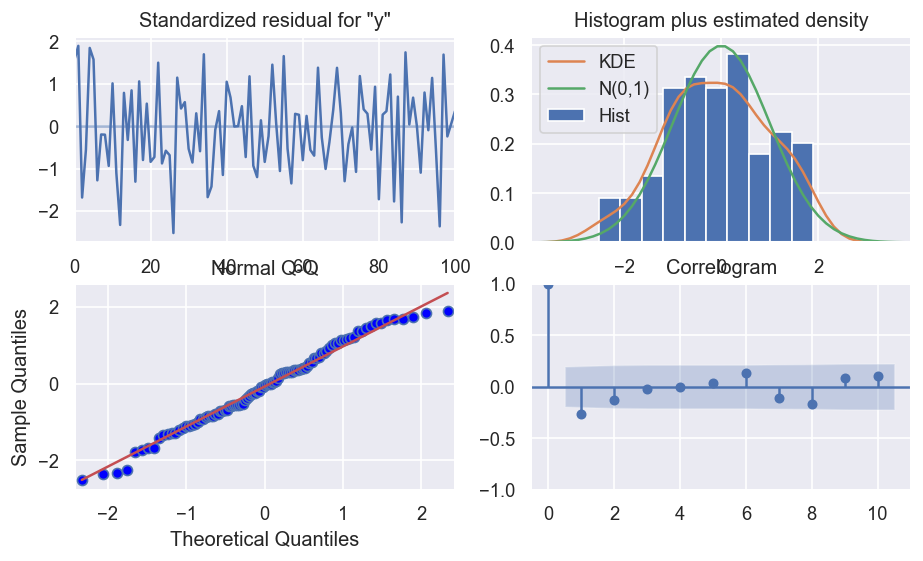

In [91]:
results2.plot_diagnostics()
plt.show()

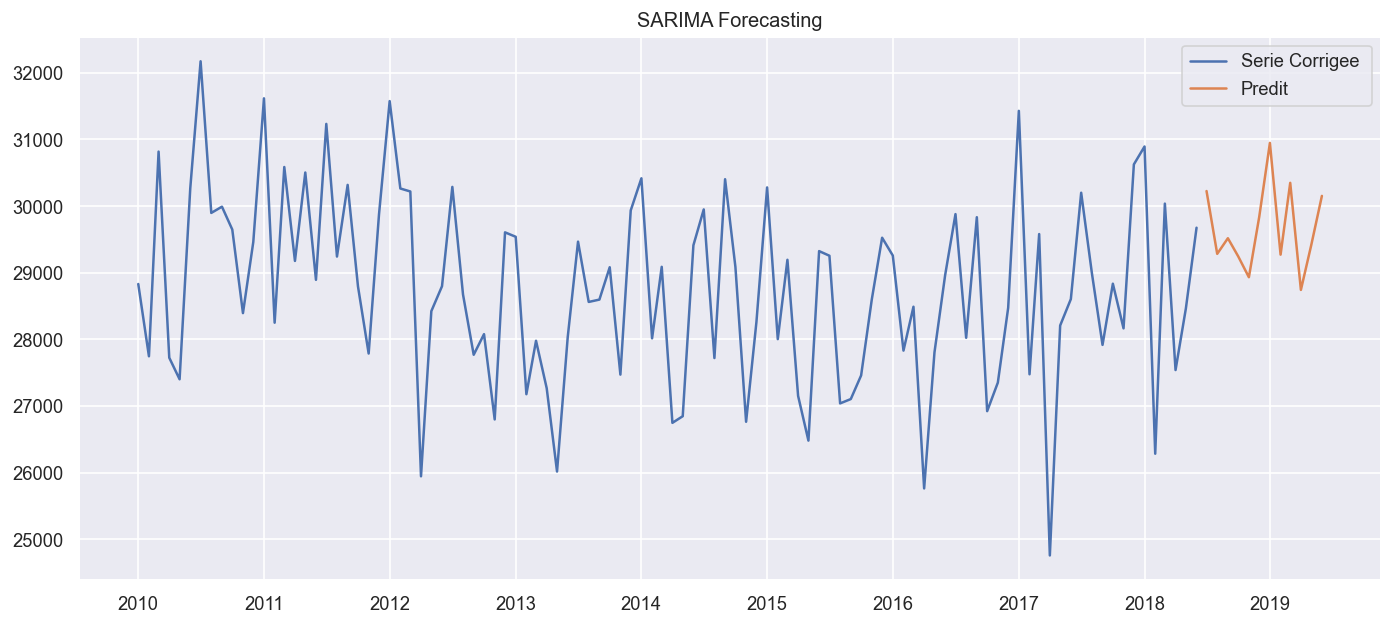

In [103]:
#prevision SARIMA
sarima_pred_2=results2.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(x_tronc['Mois'],x_tronc['corrigee'], label='Serie Corrigee ')
plt.plot(pd.date_range(x_tronc.Mois[x_tronc.shape[0]-1],
                       periods=12, freq='M'), sarima_pred_2, label='Predit')
plt.title('SARIMA Forecasting')

plt.legend()

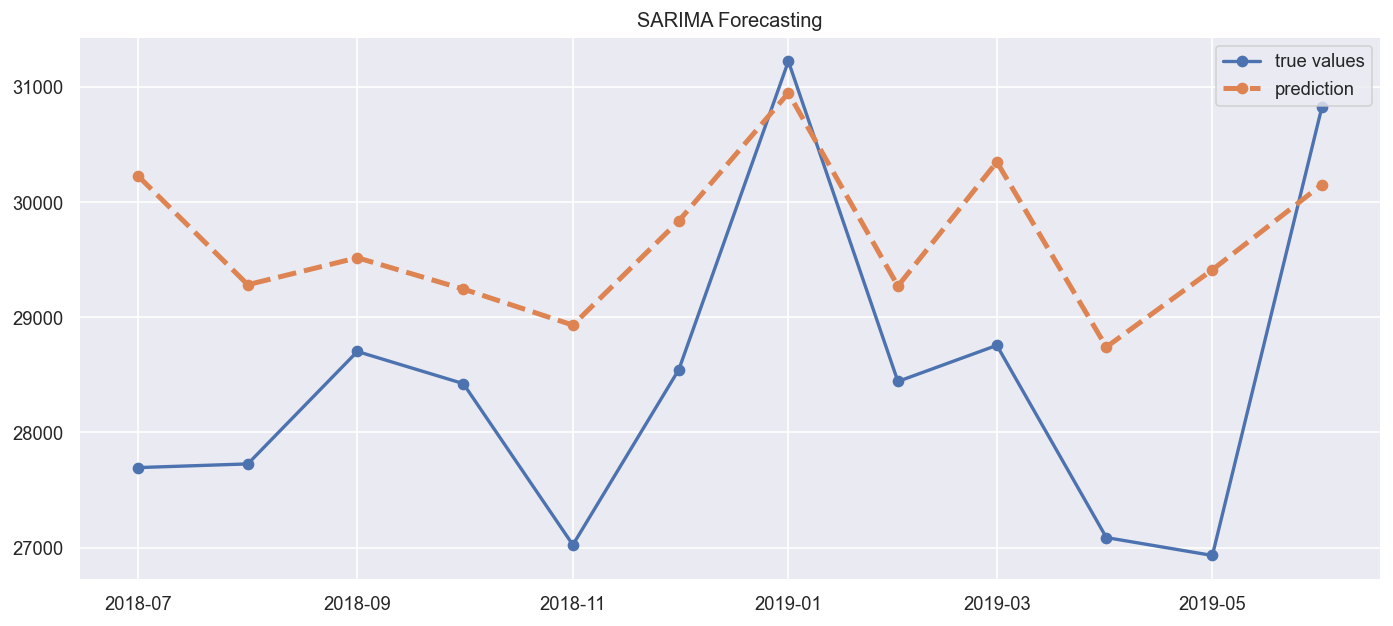

In [104]:
plt.figure(figsize=(14,6))
plt.plot(x_a_prevoir['Mois'],x_a_prevoir['corrigee'], label='true values',  marker='o', linewidth=2)
plt.plot(x_a_prevoir['Mois'],sarima_pred_2, label='prediction', linestyle='--',  marker='o', linewidth=3)
plt.title('SARIMA Forecasting')

plt.legend()

In [94]:
#racine de mean squar
np.sqrt(mean_squared_error(x_a_prevoir.corrigee, sarima_pred_2 ))

1530.7637468923315

In [95]:
#Mean absolute percentage error (MAPE) regression loss
print(f'Modèle de SARIMA optimal, mean absolute percentage error {mean_absolute_percentage_error(x_a_prevoir.corrigee, sarima_pred_2)}')

Modèle de SARIMA optimal, mean absolute percentage error 0.04908214421068249


### Prédiction pour année+1

In [96]:
y2= np.asarray(serie_corr_df["corrigee"])
hw2 = ExponentialSmoothing(y2, 
                          seasonal_periods=12, trend='add', 
                          seasonal='add').fit()
hw_pred_2 = hw2.forecast(12)

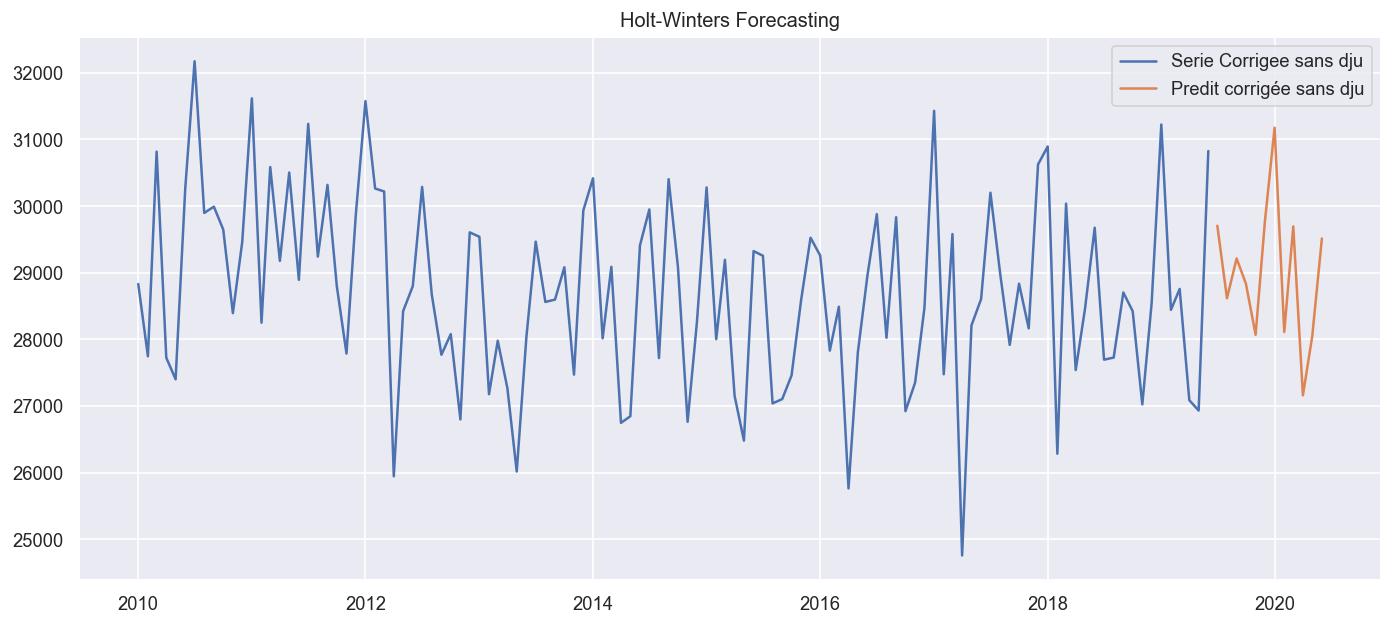

In [106]:
plt.figure(figsize=(14,6))
plt.plot(serie_corr_df['Mois'],serie_corr_df['corrigee'], label='Serie Corrigee sans dju') 
plt.plot(pd.date_range(serie_corr_df.Mois[len(y2)-1],
                       periods=12, freq='M'), hw_pred_2, label='Predit corrigée sans dju')
plt.title('Holt-Winters Forecasting')

plt.legend()

In [98]:
pd.date_range(serie_corr_df.Mois[len(y2)-1],
                       periods=12, freq='M')

DatetimeIndex(['2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30',
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31'],
              dtype='datetime64[ns]', freq='M')